In [1]:
import numpy as np
import pandas as pd
import datetime
import copy
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from sklearn import linear_model
from statsmodels.formula.api import poisson,ols,negativebinomial
from sklearn import metrics
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from scipy.special import logsumexp

import scipy.special as spsp
import scipy.stats as spst

from statsmodels.base.model import GenericLikelihoodModel

In [2]:
#reading the dataframe
new_df = pd.read_csv('datewise_data.csv',encoding='latin')

In [3]:
new_df

,DATE,count,Temperature,Visibility,cloud,humidity,Conditions,DJI,Precipitation,Snow,...,JHI_lag,MPGSX_lag,TJX_lag,TMO_lag,JHI_7_lag,MPGSX_7_lag,TJX_7_lag,TMO_7_lag,BCG_7_lag,t
0,2018-01-01,48,5.6,9.9,15.0,48.02,Clear,24824.01,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2018-01-02,13,11.6,9.9,25.6,53.38,Partially cloudy,24824.01,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2018-01-03,61,21.8,9.9,53.4,54.99,Partially cloudy,24922.68,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,2018-01-04,10,25.9,4.5,87.0,78.59,"Snow, Overcast",25075.13,0.62,6.67,...,12.898995,8.150966,36.429714,191.056091,NaN,NaN,NaN,NaN,NaN,3
4,2018-01-05,20,14.2,8.4,57.1,53.83,"Snow, Partially cloudy",25295.87,0.00,4.00,...,12.898995,8.150966,36.429714,191.056091,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2021-10-15,15,64.6,9.9,80.2,88.48,Overcast,35294.76,0.00,0.00,...,18.223978,15.600000,62.735744,575.678223,18.214185,15.657143,63.488650,579.041129,20285.714286,1116
1117,2021-10-16,12,69.8,9.9,90.5,80.83,Overcast,35258.61,0.00,0.00,...,18.204393,15.700000,63.263775,573.329163,18.235169,15.668571,63.370519,578.749817,20585.714286,1117
1118,2021-10-17,17,59.3,9.7,57.1,67.35,"Rain, Partially cloudy",35258.61,0.33,0.00,...,18.223978,16.000000,63.901390,577.117615,18.232371,15.698571,63.250965,577.870170,20621.428571,1118
1119,2021-10-18,14,53.9,9.9,61.3,57.28,Partially cloudy,35258.61,0.00,0.00,...,18.184807,16.110001,64.110611,582.155640,18.228174,15.752857,63.195457,577.651690,20657.142857,1119


In [4]:
#building the OLS model

variables = ['Temperature', 'Visibility', 'cloud', 'humidity',
       'C(Conditions)', 'DJI', 'Precipitation', 'Snow', 'snow_depth',
       'wind_speed', 'C(DAY_OF_WEEK)', 'WEEKEND', 'C(DAY_OF_MONTH)', 'C(MONTH)',
       'UNEMPLOY_RATE', 'fed_holiday', 'gov_holiday', 'nonpub_holiday',
       'reg_holiday', 'BCG', 'BSX', 'EIX', 'JHI', 'MPGSX', 'STT',
       'TJX', 'TMO',
       'JHI_7', 'MPGSX_7', 'TJX_7', 'TMO_7',
       'BSX_7', 'EIX_7', 'STT_7', 'BCG_7', 'np.log(count_lag)',  't']
model = "np.log(count)~" +variables[0]
for i in range(1,len(variables)):
    model=model+"+"+variables[i]  
print(model)

np.log(count)~Temperature+Visibility+cloud+humidity+C(Conditions)+DJI+Precipitation+Snow+snow_depth+wind_speed+C(DAY_OF_WEEK)+WEEKEND+C(DAY_OF_MONTH)+C(MONTH)+UNEMPLOY_RATE+fed_holiday+gov_holiday+nonpub_holiday+reg_holiday+BCG+BSX+EIX+JHI+MPGSX+STT+TJX+TMO+JHI_7+MPGSX_7+TJX_7+TMO_7+BSX_7+EIX_7+STT_7+BCG_7+np.log(count_lag)+t


In [5]:
#splitting the data into training, validation and testing 
training = new_df[(new_df['DATE'] >= '2018-01-01') & (new_df['DATE'] <= '2021-08-31')]
validation = new_df[(new_df['DATE'] >= '2021-09-01') & (new_df['DATE'] <= '2021-09-18')]
testing = new_df[(new_df['DATE'] >= '2021-09-19') & (new_df['DATE'] <= '2021-10-19')]

In [6]:
#running the OLS model on the training dataset and predicting on the validation dataset

Model = ols(model, training).fit()
Pred = Model.predict(validation)

In [7]:
#model with all the variables indcluded and calculating the R2 score

Pred = np.exp(Pred)
metrics.r2_score(validation['count'],Pred)

0.08447001051397962

In [8]:
#backward elimination model

def backward_elimination(new_variables):
    variables_copy=copy.copy(new_variables)
    list_A = []
    list_B = []
        
    for i in range(0,len(new_variables)):
        variables_copy = copy.copy(new_variables)
        deleted_variable = variables_copy.pop(i)
        model = "np.log(count)~" +variables_copy[0]
        for i in range(1,len(variables_copy)):
            model=model+"+"+variables_copy[i]
        Pred1=ols(model,training).fit().predict(validation)
        Pred1=np.exp(Pred1)
        list_A.append(deleted_variable)
        list_B.append(metrics.r2_score(validation['count'],Pred1))
    return list_A[list_B.index(max(list_B))], max(list_B)

In [9]:
variables.remove('C(MONTH)')

In [10]:
backward_elimination(variables)

('C(DAY_OF_MONTH)', 0.4786983547873561)

In [11]:
backward_elimination(variables)[1] >  0.4002813292735917

True

**Final model variables after running the model multiple times and the calculated R2 score

['cloud',
 'humidity',
 'DJI',
 'Precipitation',
 'WEEKEND',
 'UNEMPLOY_RATE',
 'gov_holiday',
 'BSX',
 'EIX',
 'JHI',
 'MPGSX',
 'STT',
 'TJX',
 'TJX_7',
 'TMO_7',
 'BSX_7',
 'EIX_7',
 'BCG_7',
 'np.log(count_lag)',
 't', 'gov_holiday'] ,  R2 SCORE : 0.6339107788822724**

**ELASTIC NET**

In [12]:
#dropping the null values to run the elastic net model
new_df = new_df.dropna()

In [13]:
new_df['count'] = new_df['count'].astype('int64')

In [14]:
#creating dummy variables for categorical variables
Dummy1=pd.get_dummies(new_df.Conditions,prefix="CoN",prefix_sep="",drop_first=True)
Dummy2=pd.get_dummies(new_df.DAY_OF_WEEK,prefix="DoW",prefix_sep="",drop_first=True)
Dummy3=pd.get_dummies(new_df.DAY_OF_MONTH,prefix="DoM",prefix_sep="",drop_first=True)
Dummy4=pd.get_dummies(new_df.MONTH,prefix="M",prefix_sep="",drop_first=True)
new_df=pd.concat([new_df,Dummy1,Dummy2,Dummy3,Dummy4],axis=1)

In [15]:
new_df=new_df.assign(count_lag_log=lambda x: np.log(x.count_lag))

In [16]:
df1 = pd.DataFrame(np.log(new_df['count']))

In [17]:
df1.rename(columns={'count':'count_log'}, inplace=True)

In [18]:
new_df = pd.concat([new_df, df1], axis=1)

In [19]:
new_df.drop(['count', 'count_lag', 'Conditions', 'race_label', 'Conditions_lag'], axis = 1, inplace = True)

In [20]:
training = new_df[(new_df['DATE'] >= '2018-01-01') & (new_df['DATE'] <= '2021-08-31')]
validation = new_df[(new_df['DATE'] >= '2021-09-01') & (new_df['DATE'] <= '2021-09-18')]
testing = new_df[(new_df['DATE'] >= '2021-09-19') & (new_df['DATE'] <= '2021-10-19')]

In [21]:
training.drop(['DATE'], axis=1, inplace=True)
validation.drop(['DATE'], axis=1, inplace=True)
testing.drop(['DATE'], axis=1, inplace=True)

In [22]:
#standardizing the independent variables
SSmodel=StandardScaler()
SSmodel.fit(training.iloc[:,:-1])
Train_x=SSmodel.transform(training.iloc[:,:-1])

In [23]:
Valid_x=SSmodel.transform(validation.iloc[:,:-1])

In [24]:
def R2_new(Actual, Pred):
    Error=np.sum((Actual - Pred)**2)/np.sum((Actual - Actual.mean())**2)
    return (1- Error)

In [33]:
#running the elastic net model
alpha_value=[]
number_of_independent_variables=[]
R2_score=[]
for i in np.arange(0.001,0.05,0.0005):
    ENmodel=ElasticNet(alpha=i, l1_ratio=0.1, fit_intercept=False)
    ENmodel.fit(Train_x, training.count_log.values-np.mean(training.count_log.values))
    filtered = list(filter(lambda coefficent: coefficent != 0, ENmodel.coef_))
    number_of_independent_variables.append(len(filtered))
    alpha_value.append(i)
    predict_log=ENmodel.predict(Valid_x)+np.mean(training.count_log.values)
    R2_score.append(R2_new(np.exp(validation.count_log.values), np.exp(predict_log)))

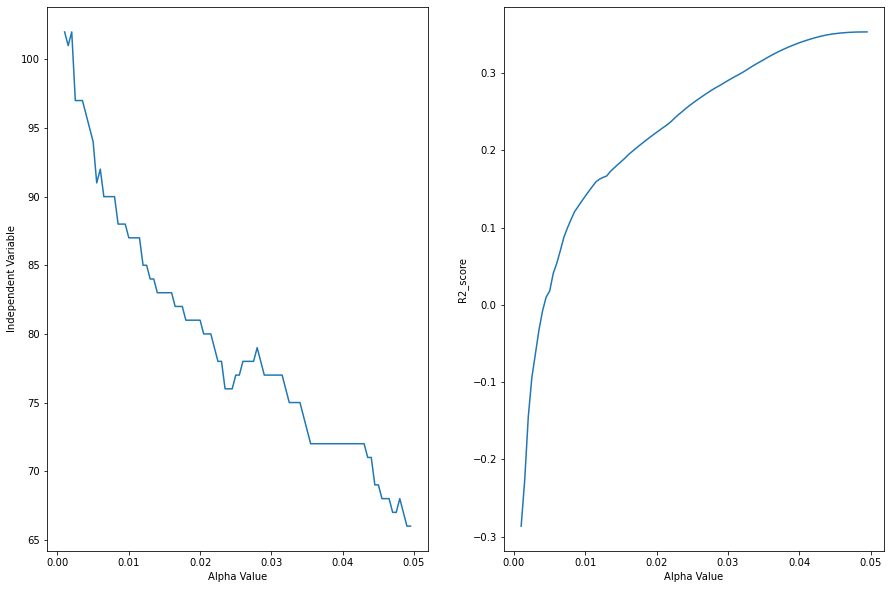

In [34]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(alpha_value, number_of_independent_variables)
plt.xlabel('Alpha Value')
plt.ylabel('Independent Variable')
plt.subplot(1,2,2)
plt.plot(alpha_value, R2_score)
plt.xlabel('Alpha Value')
plt.ylabel('R2_score')
plt.show()

In [35]:
alpha_value[R2_score.index(max(R2_score))],R2_score[R2_score.index(max(R2_score))]

(0.0495, 0.3535177785986726)

In [36]:
number_of_independent_variables[R2_score.index(max(R2_score))]

66